In [43]:
import networkx as nx 
import numpy as np
import torch 
import torch_geometric
from matplotlib import pyplot as plt
import seaborn as sbn
import pandas as pd

In [4]:
KCG = torch_geometric.datasets.KarateClub()
KCG.data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [29]:
G = nx.Graph() 
_ = [G.add_node(i, y=yy) for i,yy in enumerate(KCG.data.y.numpy())]
G.add_edges_from([(a.item(),b.item()) for a,b in zip(*KCG.data.edge_index)])

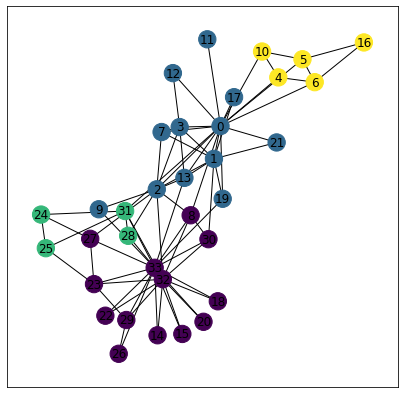

In [163]:
plt.figure(figsize=(7,7))
nx.draw_networkx(G, node_color=list(nx.get_node_attributes(G, 'y').values()))
plt.show()

In [46]:
num_nodes = KCG.data.num_nodes
dim = 2 
y = KCG.data.y

z = torch.randn((num_nodes, dim))
print('z shape', z.size())
print('z sample:\n', z[0:5,:])

z shape torch.Size([34, 2])
z sample:
 tensor([[ 1.1087,  0.0827],
        [-0.8272, -1.6065],
        [-0.1171, -1.1740],
        [ 0.2913,  0.8294],
        [ 1.6037,  1.0769]])


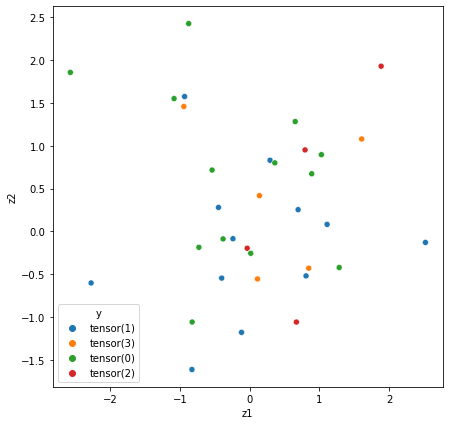

In [51]:
# e.g., z[i, :] is the embedding of node i 

def plot_embedding(z, y, figsize=(7,7)): 
    df = pd.DataFrame({'z1': z[:, 0].numpy(), 'z2':z[:,1], 'y':[str(yy) for yy in y]})
    plt.figure(figsize=figsize)
    sbn.scatterplot(x='z1',y='z2', hue='y', data=df)
    plt.show()

plot_embedding(z,y)

In [59]:
# set up our probability function 
def P(z): 
    
    return torch.softmax(z @ z.T, dim=-1)

probs = P(z)
print('size of probability matrix:', probs.size())
print('num nodes:', num_nodes)

# interpretable as the probability from i,j at P[i,j] =/= P[j,i]
# NOTE: is our matrix symmetric? Why not 

size of probability matrix: torch.Size([34, 34])
num nodes: 34


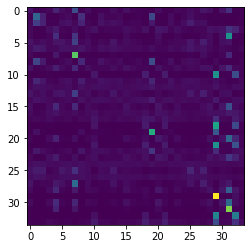

In [62]:
plt.figure()
plt.imshow(probs)
plt.show()

In [70]:
A = nx.adjacency_matrix(G).todense()

matrix([[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0]], dtype=int32)

We can get the probability matrix (e.g., the probability of transition from i,j via random walk) using the formula: 

Transition matrix (T) 

$$ D = $$

$$ T = $$

$ p $$

https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx

In [80]:
def random_walk_prob(G, path=5, iterations=1000): 
    '''
    
    Args:
        G (nx graph): 
        path (int): path length
        
    '''
    probs = np.zeros((num_nodes, num_nodes))
    for node in range(num_nodes): 
        

        for j in range(iterations):
            prev_node = node
            
            for i in range(path): 
                next_node = np.random.choice(list(G.neighbors(prev_node)))
                prev_node = next_node
        
            probs[node, next_node] += 1/iterations

    return probs

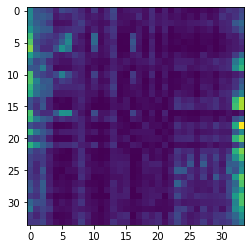

In [81]:
true_probs = random_walk_prob(G)

plt.figure()
plt.imshow(true_probs)
plt.show()

In [155]:
class RW_model(torch.nn.Module): 
    def __init__(self): 
        super(RW_model, self).__init__()
        self.z = torch.nn.Parameter( torch.randn((num_nodes, dim), dtype=torch.float) )
        self.y = KCG.data.y

    def forward(self): 
        return torch.softmax(self.z @ self.z.T, dim=-1) 

    def plot_embedding(self, figsize=(7,7), save=None, epoch=0): 
        df = pd.DataFrame({'z1': self.z[:, 0].detach().numpy(), 'z2':self.z.detach()[:,1], 'y':[str(yy) for yy in self.y.detach().numpy()]})
        plt.figure(figsize=figsize)
        sbn.scatterplot(x='z1',y='z2', hue='y', data=df)
        #plt.xlim(-3,3)
        #plt.ylim(-3,3)
        plt.title(f'Epoch: {epoch}')

        if save is not None: 
            plt.savefig(save) 
        else: 
            plt.show()
      
        

In [159]:
model = RW_model()
optim = torch.optim.Adam(model.parameters(), lr=5e-3)
mse = torch.nn.MSELoss()

In [160]:
y = torch.tensor( random_walk_prob(G), dtype=torch.float)
y.size()

torch.Size([34, 34])

In [161]:
for epoch in range(10000): 

    optim.zero_grad() 
    yhat = model() 
    loss = mse(y, yhat)
    loss.backward()
    optim.step()
    if epoch % 50 == 0: 
        print(f'epoch: {epoch} \t\t| loss: {loss.item()}', end='\r')
        model.plot_embedding(save=f'./output/embed_{epoch}.PNG', epoch=epoch)
        plt.close('all')

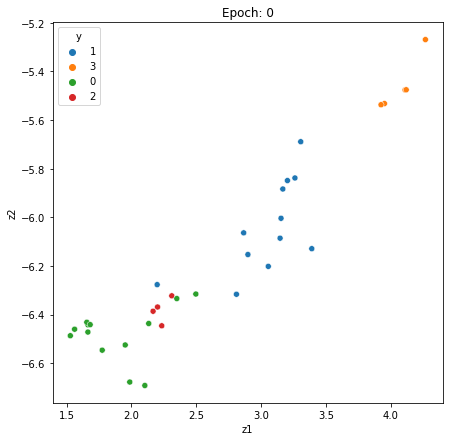

In [162]:
model.plot_embedding()